In [1]:
import pandas as pd
import joblib
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import load_model
import time
import matplotlib.pyplot as plt

In [2]:
test_data = pd.read_csv(rf"./CMAPSSData/test_FD004.txt", sep = " ", header = None, index_col = None)
test_data

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,20.0072,0.7000,100.0,491.19,606.67,1481.04,1227.81,9.35,...,8048.98,9.2229,0.02,362,2324,100.00,24.31,14.7007,NaN,NaN
1,1,2,24.9984,0.6200,60.0,462.54,536.22,1256.17,1031.48,7.05,...,7863.46,10.8632,0.02,306,1915,84.93,14.36,8.5748,NaN,NaN
2,1,3,42.0000,0.8420,100.0,445.00,549.23,1340.13,1105.88,3.91,...,8071.13,9.3960,0.02,328,2212,100.00,10.39,6.4365,NaN,NaN
3,1,4,42.0035,0.8402,100.0,445.00,549.19,1339.70,1107.26,3.91,...,8078.89,9.3594,0.02,328,2212,100.00,10.56,6.2367,NaN,NaN
4,1,5,35.0079,0.8400,100.0,449.44,555.10,1353.04,1117.80,5.48,...,8057.83,9.3030,0.02,333,2223,100.00,14.85,8.9326,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41209,248,277,41.9991,0.8401,100.0,445.00,550.30,1364.40,1129.17,3.91,...,8112.61,9.4427,0.02,331,2212,100.00,10.53,6.2620,NaN,NaN
41210,248,278,20.0026,0.7005,100.0,491.19,608.00,1494.75,1260.88,9.35,...,8086.83,9.2772,0.02,366,2324,100.00,24.33,14.6486,NaN,NaN
41211,248,279,34.9988,0.8413,100.0,449.44,555.92,1370.65,1130.97,5.48,...,8100.84,9.3982,0.02,336,2223,100.00,14.69,8.8389,NaN,NaN
41212,248,280,20.0027,0.7000,100.0,491.19,608.19,1489.11,1256.25,9.35,...,8085.24,9.2727,0.03,366,2324,100.00,24.44,14.6887,NaN,NaN


In [3]:
def obtain_RUL(number):
    nombres_columnas = ['RUL','unit']
    df = pd.read_csv(rf"./CMAPSSData/RUL_FD00{number}.txt",sep = " ", header = None, index_col = None)
    df.columns =   nombres_columnas
    df['unit'] = range(1, len(df) + 1)
    return df

In [4]:
def create_test_df(number):
    nombres_columnas = ['unit', 'cycle', 'op_setting_1', 'op_setting_2', 'op_setting_3']
    nombres_columnas += [f'sensor_{i}' for i in range(1, 24)]
    df = pd.read_csv(rf"./CMAPSSData/test_FD00{number}.txt",sep = " ", header = None, index_col = None)
    df.columns =   nombres_columnas
    df.dropna(how='all', axis=1, inplace = True)
    rul_df = obtain_RUL(number)
    max_cycles = df.groupby('unit')['cycle'].max().reset_index()
    max_cycles.columns = ['unit', 'max_cycle']
    temp_df = pd.merge(df[['unit', 'cycle']], max_cycles, on='unit')
    temp_df = pd.merge(temp_df, rul_df, on='unit')
    temp_df['RUL'] = temp_df['RUL'] + (temp_df['max_cycle'] - temp_df['cycle'])
    df = pd.merge(df, temp_df[['unit', 'cycle', 'RUL']], on=['unit', 'cycle'])
    return df

In [5]:
def plot_scatter(y_test, y_pred, name):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5, label='Predicciones')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal')
    plt.xlabel('RUL Real')
    plt.ylabel('RUL Predicho')
    plt.title('Comparación entre RUL Real y Predicho')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [6]:
test_data = create_test_df(4)

In [7]:
def data_transformer(df, pca = 1):
    scaler = joblib.load('scaler.pkl')
    y = df[['unit', 'cycle','RUL']]
    X = df.drop(['unit', 'cycle','RUL'], axis = 1)
    X_scaled = pd.DataFrame(scaler.transform(X),columns=X.columns)
    if pca == 1:
        X_result = X_scaled[['sensor_14','sensor_11','sensor_16','sensor_4', 'sensor_17', 'sensor_3', 'sensor_9']]
        pca = joblib.load('pca.pkl')
        X_descartes = X_scaled[['op_setting_1', 'op_setting_2', 'op_setting_3', 'sensor_1',
                       'sensor_2', 'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8',
                       'sensor_10', 'sensor_12', 'sensor_13', 'sensor_15', 'sensor_18',
                       'sensor_19', 'sensor_20', 'sensor_21']]
        X_pca = pd.DataFrame(pca.transform(X_descartes),columns=['pca_1','pca_2','pca_3'])
        X_result = pd.concat([X_result, X_pca], axis=1)
        return X_result, y
    else:
        return X_scaled, y

In [8]:
def predict_test(modelname, df, pca):
    data, results = data_transformer(df, pca=pca)
    y_test = results[['RUL']]
    model = joblib.load(modelname)
    y_pred = model.predict(data)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"RMSE test: {rmse:.4f}")
    print(f"MAE test: {mae:.4f}")
    print(f"R² Score test: {r2:.4f}")

    return y_pred

In [9]:
test_data = create_test_df(4)
test_data[test_data['unit'] == 1]

,unit,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL
0,1,1,20.0072,0.7000,100.0,491.19,606.67,1481.04,1227.81,9.35,...,2387.78,8048.98,9.2229,0.02,362,2324,100.00,24.31,14.7007,251
1,1,2,24.9984,0.6200,60.0,462.54,536.22,1256.17,1031.48,7.05,...,2028.09,7863.46,10.8632,0.02,306,1915,84.93,14.36,8.5748,250
2,1,3,42.0000,0.8420,100.0,445.00,549.23,1340.13,1105.88,3.91,...,2387.95,8071.13,9.3960,0.02,328,2212,100.00,10.39,6.4365,249
3,1,4,42.0035,0.8402,100.0,445.00,549.19,1339.70,1107.26,3.91,...,2387.90,8078.89,9.3594,0.02,328,2212,100.00,10.56,6.2367,248
4,1,5,35.0079,0.8400,100.0,449.44,555.10,1353.04,1117.80,5.48,...,2387.87,8057.83,9.3030,0.02,333,2223,100.00,14.85,8.9326,247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,1,226,0.0018,0.0019,100.0,518.67,642.33,1592.22,1406.67,14.62,...,2388.22,8162.71,8.2953,0.03,394,2388,100.00,39.46,23.5819,26
226,1,227,35.0068,0.8414,100.0,449.44,555.47,1369.11,1133.25,5.48,...,2388.44,8092.23,9.1952,0.02,335,2223,100.00,14.90,8.9485,25
227,1,228,42.0010,0.8418,100.0,445.00,549.45,1352.89,1129.70,3.91,...,2388.40,8112.49,9.2161,0.02,332,2212,100.00,10.65,6.5274,24
228,1,229,42.0055,0.8400,100.0,445.00,549.45,1356.32,1129.66,3.91,...,2388.45,8109.04,9.2439,0.02,331,2212,100.00,10.54,6.3622,23


In [10]:
data, results = data_transformer(test_data, pca = 0)
results[results['unit'] == 1]

,unit,cycle,RUL
0,1,1,251
1,1,2,250
2,1,3,249
3,1,4,248
4,1,5,247
...,...,...,...
225,1,226,26
226,1,227,25
227,1,228,24
228,1,229,23


In [11]:
%%time
y_pred_XGB_final = predict_test('./final_models/xgb_model_final.pkl', test_data, pca=1)

RMSE test: 75.1172
MAE test: 55.4989
R² Score test: 0.3358
CPU times: total: 1.45 s
Wall time: 295 ms


In [12]:
%%time
y_pred_RFR_final = predict_test('./final_models/RFR_model_final.pkl', test_data, pca=1)

RMSE test: 75.1343
MAE test: 55.5296
R² Score test: 0.3355
CPU times: total: 4.14 s
Wall time: 2.62 s


In [13]:
%%time
y_pred_XGB_scaled = predict_test('./final_models/xgb_model_scaled.pkl', test_data, pca=0)

RMSE test: 72.1825
MAE test: 53.2572
R² Score test: 0.3867
CPU times: total: 1.55 s
Wall time: 126 ms


In [14]:
%%time
y_pred_RFR_scaled = predict_test('./final_models/RFR_model_scaled.pkl', test_data, pca=0)

RMSE test: 72.1826
MAE test: 53.3514
R² Score test: 0.3867
CPU times: total: 4.22 s
Wall time: 2.66 s


In [15]:
def LSTM_secuencia_2(df,ventana=30, pca = 0, todo = False):
    max_cycle_by_unit = df.groupby('unit')['cycle'].transform('max')
    secuencias = []
    etiquetas = []
    df_valores, perder = data_transformer(df, pca=pca)
    df_no_escaladas = df[['unit','cycle', 'RUL']]
    df_combinado = pd.concat([df_no_escaladas, df_valores], axis= 1)
    for motor, grupo in df_combinado.groupby('unit'):
        grupo = grupo.sort_values('cycle')
        valores = grupo[df_valores.columns].values
        if todo == False:
            if len(valores) >= ventana:
                ventana_final = valores[-ventana:]
            else:
                padding = np.zeros((ventana - len(valores), valores.shape[1]))
                ventana_final = np.vstack((padding, valores))
            secuencias.append(ventana_final)
            etiquetas.append(grupo.RUL.values[-1])
        else:    
            rul_valores = grupo.RUL.values
            for i in range(len(grupo) - ventana + 1):
                X_ventana = valores[i:i+ventana]
                y_ventana = rul_valores[i+ventana - 1]
                secuencias.append(X_ventana)
                etiquetas.append(y_ventana)
    return np.array(secuencias), np.array(etiquetas)

In [16]:
X_LSTM_scaled, Y_LSTM_scaled = LSTM_secuencia_2(test_data, ventana=40, todo = True)

In [17]:
X_LSTM_final, Y_LSTM_final = LSTM_secuencia_2(test_data, ventana=40, pca = 1, todo = True)

In [18]:
model = load_model('./final_models/best_lstm_model_final_kt.h5',compile=False)
y_pred_LSTM_final_all = model.predict(X_LSTM_final)
rmse = np.sqrt(mean_squared_error(Y_LSTM_final, y_pred_LSTM_final_all))
mae = mean_absolute_error(Y_LSTM_final, y_pred_LSTM_final_all)
r2 = r2_score(Y_LSTM_final, y_pred_LSTM_final_all)


print(f"RMSE test: {rmse:.4f}")
print(f"MAE test: {mae:.4f}")
print(f"R² Score test: {r2:.4f}")

992/992 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
RMSE test: 77.2638
MAE test: 57.6417
R² Score test: 0.2322


In [19]:
model = load_model('./final_models/best_lstm_model_scaled_kt.h5',compile=False)
y_pred_LSTM_scaled_all = model.predict(X_LSTM_scaled)
rmse = np.sqrt(mean_squared_error(Y_LSTM_scaled, y_pred_LSTM_scaled_all))
mae = mean_absolute_error(Y_LSTM_scaled, y_pred_LSTM_scaled_all)
r2 = r2_score(Y_LSTM_scaled, y_pred_LSTM_scaled_all)

print(f"RMSE test: {rmse:.4f}")
print(f"MAE test: {mae:.4f}")
print(f"R² Score test: {r2:.4f}")

992/992 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
RMSE test: 80.3160
MAE test: 59.4777
R² Score test: 0.1704


In [20]:
test_data

,unit,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL
0,1,1,20.0072,0.7000,100.0,491.19,606.67,1481.04,1227.81,9.35,...,2387.78,8048.98,9.2229,0.02,362,2324,100.00,24.31,14.7007,251
1,1,2,24.9984,0.6200,60.0,462.54,536.22,1256.17,1031.48,7.05,...,2028.09,7863.46,10.8632,0.02,306,1915,84.93,14.36,8.5748,250
2,1,3,42.0000,0.8420,100.0,445.00,549.23,1340.13,1105.88,3.91,...,2387.95,8071.13,9.3960,0.02,328,2212,100.00,10.39,6.4365,249
3,1,4,42.0035,0.8402,100.0,445.00,549.19,1339.70,1107.26,3.91,...,2387.90,8078.89,9.3594,0.02,328,2212,100.00,10.56,6.2367,248
4,1,5,35.0079,0.8400,100.0,449.44,555.10,1353.04,1117.80,5.48,...,2387.87,8057.83,9.3030,0.02,333,2223,100.00,14.85,8.9326,247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41209,248,277,41.9991,0.8401,100.0,445.00,550.30,1364.40,1129.17,3.91,...,2388.50,8112.61,9.4427,0.02,331,2212,100.00,10.53,6.2620,30
41210,248,278,20.0026,0.7005,100.0,491.19,608.00,1494.75,1260.88,9.35,...,2388.33,8086.83,9.2772,0.02,366,2324,100.00,24.33,14.6486,29
41211,248,279,34.9988,0.8413,100.0,449.44,555.92,1370.65,1130.97,5.48,...,2388.64,8100.84,9.3982,0.02,336,2223,100.00,14.69,8.8389,28
41212,248,280,20.0027,0.7000,100.0,491.19,608.19,1489.11,1256.25,9.35,...,2388.37,8085.24,9.2727,0.03,366,2324,100.00,24.44,14.6887,27


In [21]:
len(X_LSTM_scaled)

31725

In [22]:
X_LSTM_scaled_last, Y_LSTM_scaled_last = LSTM_secuencia_2(test_data, ventana=40, todo = False)

In [23]:
X_LSTM_final_last, Y_LSTM_final_last = LSTM_secuencia_2(test_data, ventana=40, pca = 1, todo = False)

In [24]:
model = load_model('./final_models/best_lstm_model_scaled_kt.h5',compile=False)
y_pred_LSTM_Scaled_end = model.predict(X_LSTM_scaled_last)
rmse = np.sqrt(mean_squared_error(Y_LSTM_scaled_last, y_pred_LSTM_Scaled_end))
mae = mean_absolute_error(Y_LSTM_scaled_last, y_pred_LSTM_Scaled_end)
r2 = r2_score(Y_LSTM_scaled_last, y_pred_LSTM_Scaled_end)

print(f"RMSE test: {rmse:.4f}")
print(f"MAE test: {mae:.4f}")
print(f"R² Score test: {r2:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step 
RMSE test: 45.6033
MAE test: 33.2209
R² Score test: 0.3004


In [25]:
model = load_model('./final_models/best_lstm_model_final_kt.h5',compile=False)
y_pred_LSTM_final_end = model.predict(X_LSTM_final_last)
rmse = np.sqrt(mean_squared_error(Y_LSTM_final_last, y_pred_LSTM_final_end))
mae = mean_absolute_error(Y_LSTM_final_last, y_pred_LSTM_final_end)
r2 = r2_score(Y_LSTM_final_last, y_pred_LSTM_final_end)


print(f"RMSE test: {rmse:.4f}")
print(f"MAE test: {mae:.4f}")
print(f"R² Score test: {r2:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step 
RMSE test: 46.1324
MAE test: 33.0679
R² Score test: 0.2841


In [26]:
print(type(Y_LSTM_final_last))

<class 'numpy.ndarray'>


In [27]:
def plot_rul_comparacion(results_df, y_pred, unidades=None, titulo="Comparación RUL real vs predicho", max_leyenda=10):
    if len(results_df) != len(y_pred):
        raise ValueError("Longitudes no coinciden entre el DataFrame y las predicciones.")
    
    comparacion = results_df.copy().reset_index(drop=True)
    comparacion['RUL_predicho'] = y_pred.flatten()

    if unidades is not None:
        comparacion = comparacion[comparacion['unit'].isin(unidades)]

    unidades_unicas = sorted(comparacion['unit'].unique())
    n_unidades = len(unidades_unicas)

    cmap = plt.cm.get_cmap('tab20', n_unidades)

    plt.figure(figsize=(10, 7))

    for idx, unidad in enumerate(unidades_unicas):
        df_unidad = comparacion[comparacion['unit'] == unidad]
        plt.scatter(df_unidad['RUL'], df_unidad['RUL_predicho'], 
                    color=cmap(idx), label=f'Unidad {unidad}', alpha=0.6, s=30)

    min_rul = comparacion[['RUL', 'RUL_predicho']].min().min()
    max_rul = comparacion[['RUL', 'RUL_predicho']].max().max()
    plt.plot([min_rul, max_rul], [min_rul, max_rul], 'r--', label='Ideal (y = x)')

    plt.xlabel("RUL Real")
    plt.ylabel("RUL Predicho")
    plt.title(titulo if unidades is None else f"{titulo} (unidades: {unidades})")
    
    if n_unidades <= max_leyenda:
        plt.legend(loc='best', fontsize='small')
    
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'{titulo}.png')
    plt.show()

In [28]:
unidades_disponibles = results['unit'].unique()
motores_aleatorios = np.random.choice(unidades_disponibles, size=7, replace=False)
print(motores_aleatorios)

[202 164 122 109 104  54 177]


C:\Users\Borja\AppData\Local\Temp\ipykernel_3532\4176568992.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', n_unidades)


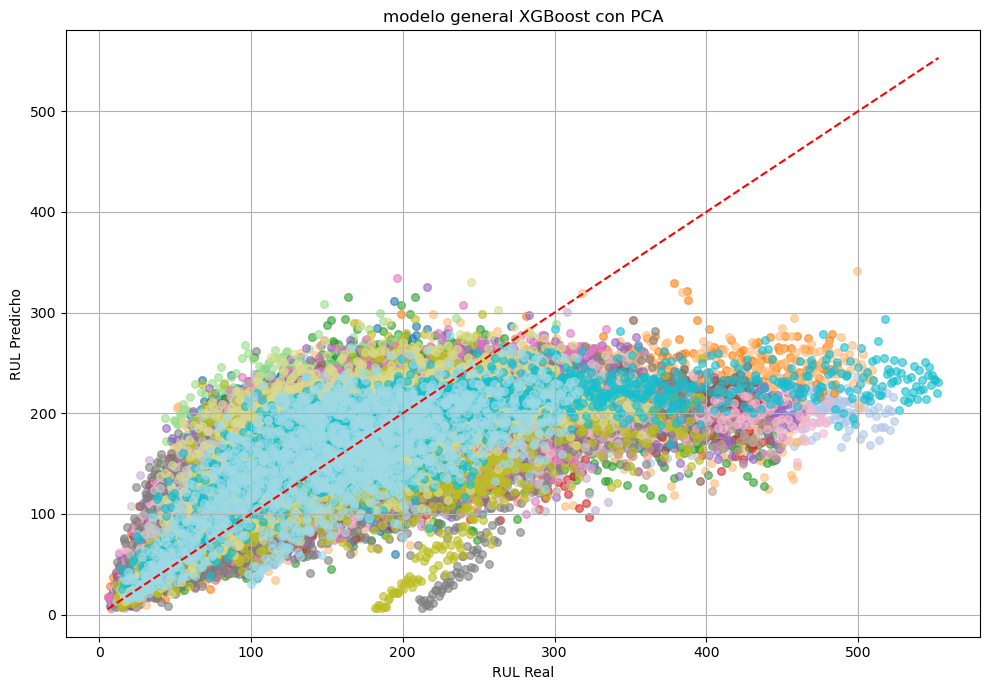

In [29]:
plot_rul_comparacion(results, y_pred_XGB_final, titulo = 'modelo general XGBoost con PCA')

C:\Users\Borja\AppData\Local\Temp\ipykernel_3532\4176568992.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', n_unidades)


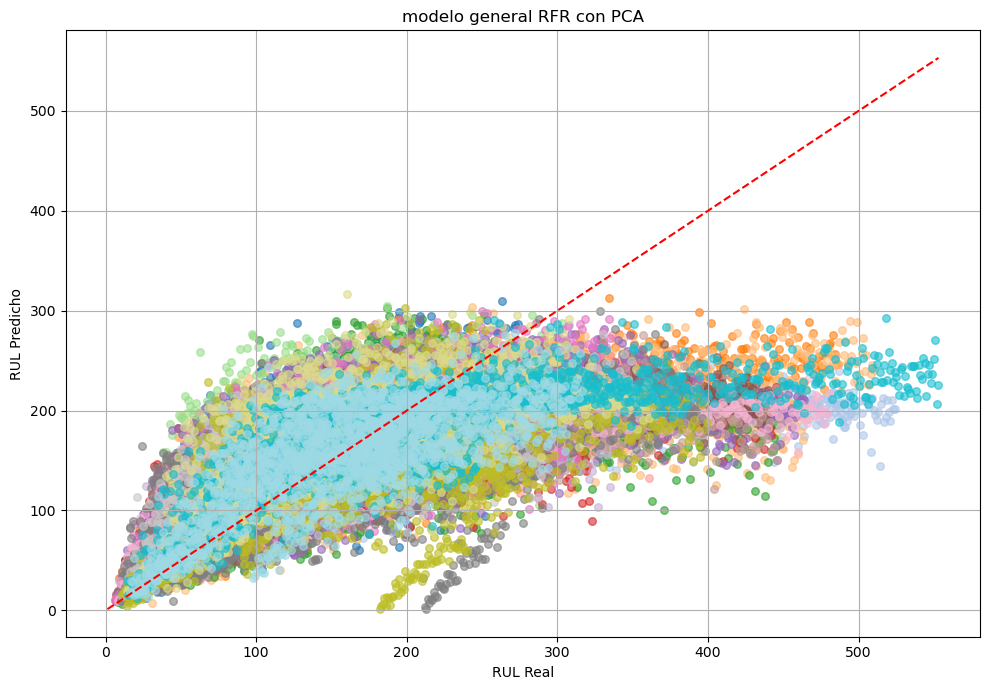

In [30]:
plot_rul_comparacion(results, y_pred_RFR_final,titulo = 'modelo general RFR con PCA')

C:\Users\Borja\AppData\Local\Temp\ipykernel_3532\4176568992.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', n_unidades)


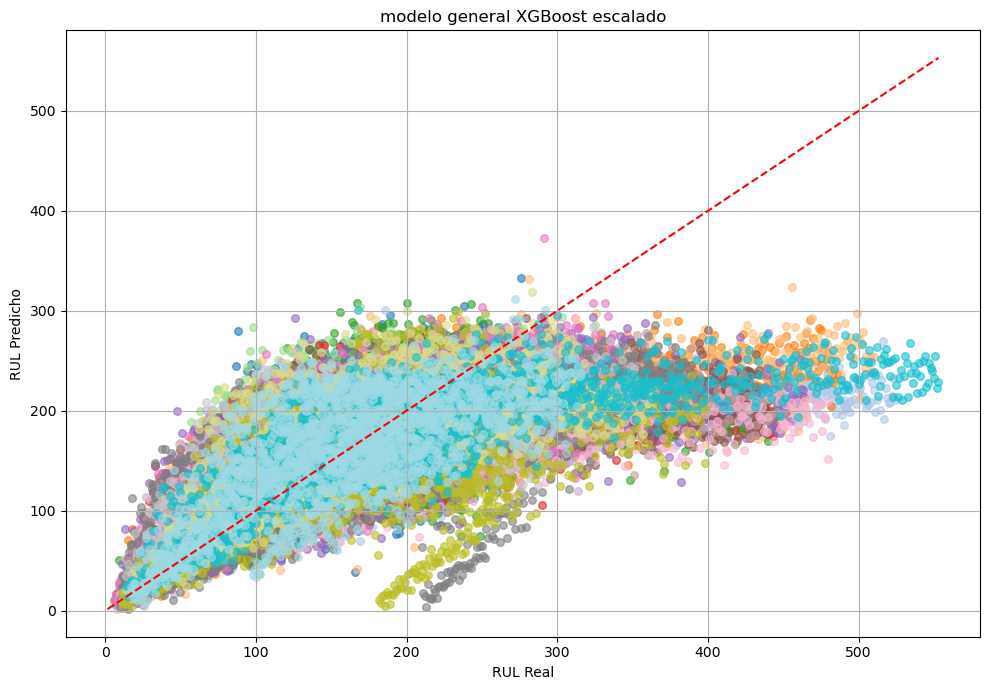

In [31]:
plot_rul_comparacion(results, y_pred_XGB_scaled, titulo = 'modelo general XGBoost escalado')

C:\Users\Borja\AppData\Local\Temp\ipykernel_3532\4176568992.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', n_unidades)


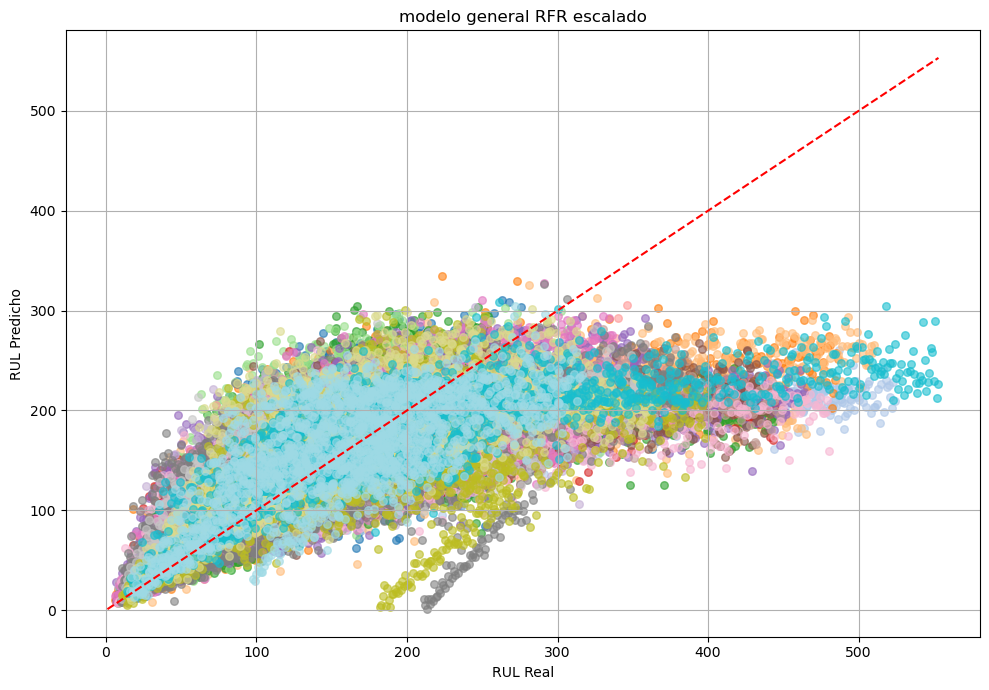

In [32]:
plot_rul_comparacion(results, y_pred_RFR_scaled, titulo = 'modelo general RFR escalado')

In [33]:
def plot_rul_predicciones(y_true: np.ndarray, y_pred: np.ndarray, titulo = "Predicción vs Realidad del RUL"):
    plt.figure(figsize=(10,7))
    plt.scatter(y_true, y_pred, alpha=0.5, label='Predicciones')
    
    # Línea diagonal ideal
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    
    plt.xlabel('RUL real')
    plt.ylabel('RUL predicho')
    plt.title(titulo)
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.savefig(f'{titulo}.png')
    plt.show()

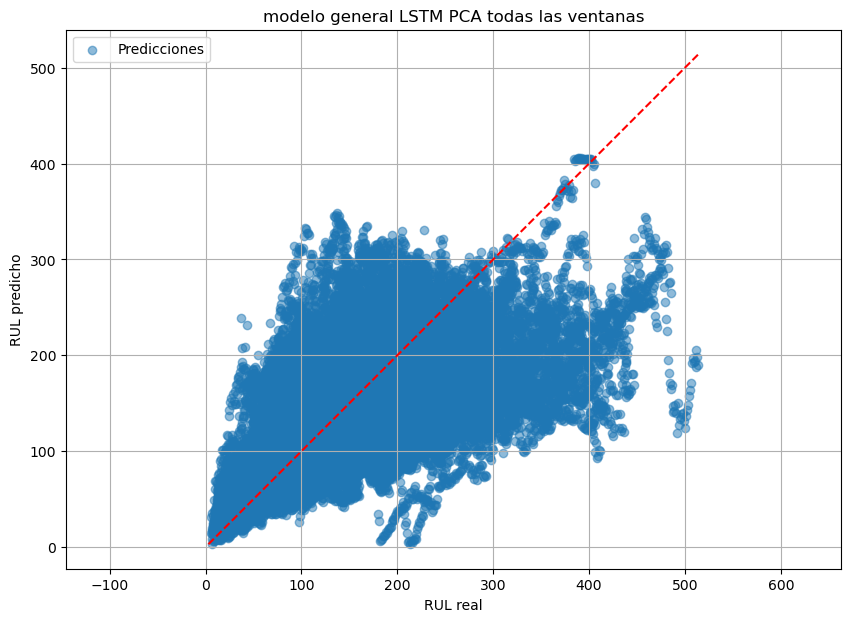

In [34]:
plot_rul_predicciones(Y_LSTM_final, y_pred_LSTM_final_all, titulo = 'modelo general LSTM PCA todas las ventanas')

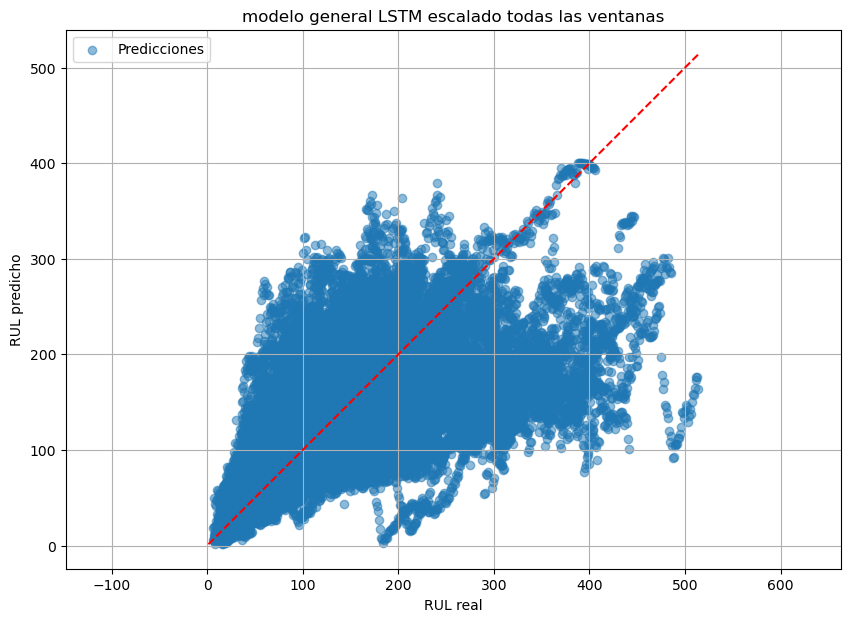

In [35]:
plot_rul_predicciones(Y_LSTM_scaled, y_pred_LSTM_scaled_all, titulo = 'modelo general LSTM escalado todas las ventanas')

In [36]:
results_last = results.loc[results.groupby('unit')['cycle'].idxmax()]
results_last

,unit,cycle,RUL
229,1,230,22
382,2,153,39
523,3,141,107
731,4,208,75
782,5,51,149
...,...,...,...
40746,244,184,35
40809,245,63,131
40838,246,29,194
40932,247,94,112


In [37]:
len(y_pred_LSTM_Scaled_end)

248

C:\Users\Borja\AppData\Local\Temp\ipykernel_3532\4176568992.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', n_unidades)


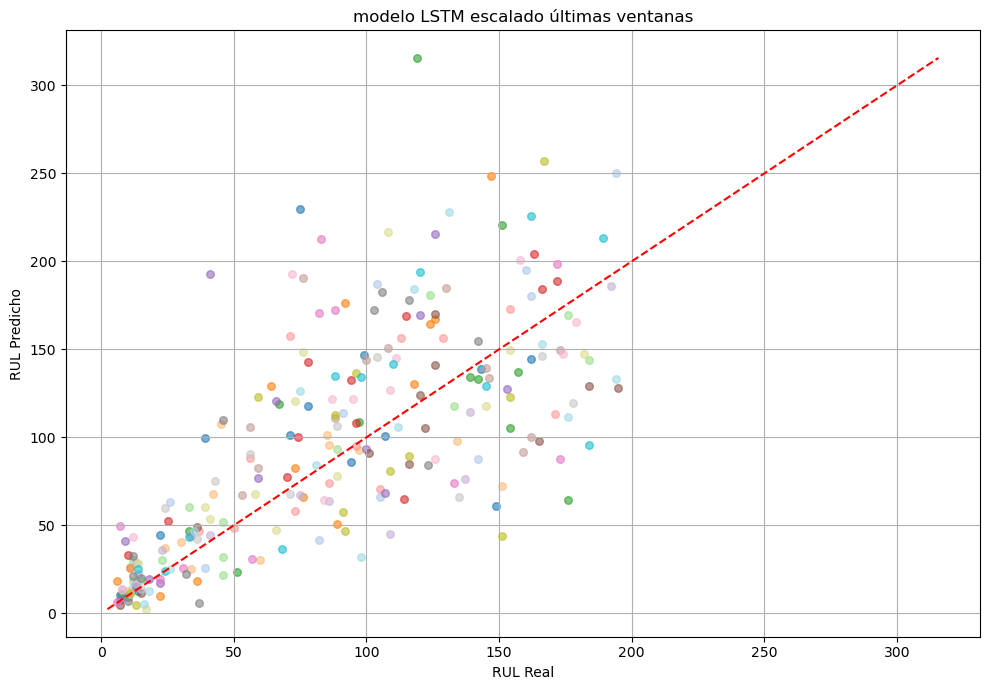

In [38]:
plot_rul_comparacion(results_last, y_pred_LSTM_Scaled_end, titulo = 'modelo LSTM escalado últimas ventanas')

C:\Users\Borja\AppData\Local\Temp\ipykernel_3532\4176568992.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', n_unidades)


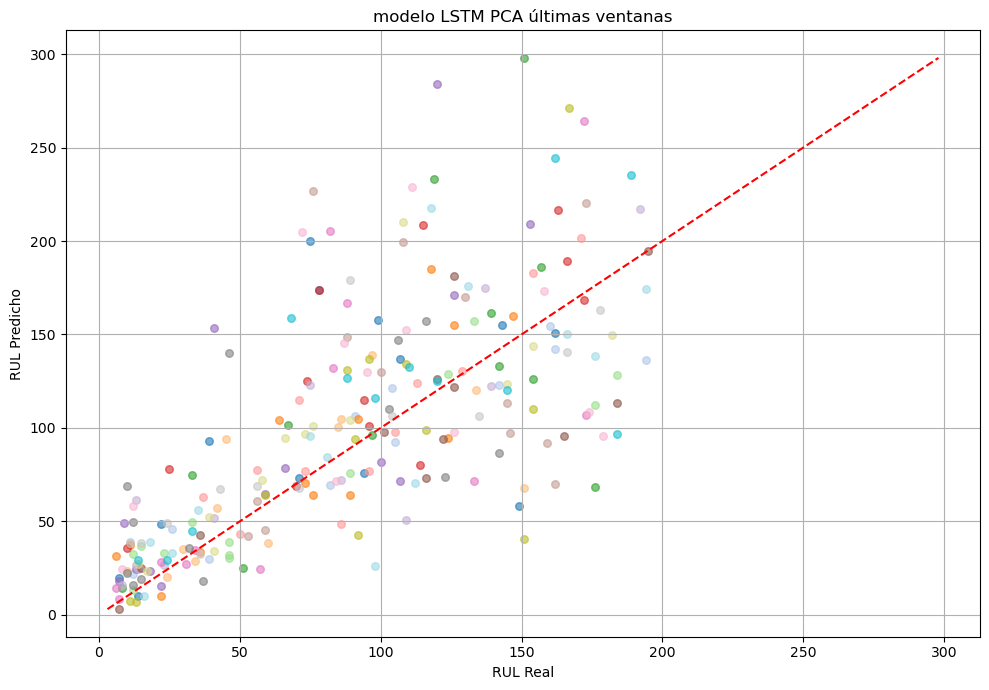

In [39]:
plot_rul_comparacion(results_last, y_pred_LSTM_final_end, titulo = 'modelo LSTM PCA últimas ventanas')

In [40]:
results['XGB_final'] = y_pred_XGB_final
results['XGB_scaled'] = y_pred_XGB_scaled
results['RFR_final'] = y_pred_RFR_final
results['RFR_scaled'] = y_pred_RFR_scaled
results[results['unit']==200]

C:\Users\Borja\AppData\Local\Temp\ipykernel_3532\1437258137.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['XGB_final'] = y_pred_XGB_final
C:\Users\Borja\AppData\Local\Temp\ipykernel_3532\1437258137.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['XGB_scaled'] = y_pred_XGB_scaled
C:\Users\Borja\AppData\Local\Temp\ipykernel_3532\1437258137.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

,unit,cycle,RUL,XGB_final,XGB_scaled,RFR_final,RFR_scaled
33673,200,1,210,142.784286,147.780945,153.598987,145.395260
33674,200,2,209,131.527832,157.653137,130.605239,145.057452
33675,200,3,208,154.381699,144.862289,144.965577,159.778453
33676,200,4,207,142.636093,151.384918,146.700185,145.035490
33677,200,5,206,133.565445,152.008972,137.595638,149.479949
...,...,...,...,...,...,...,...
33783,200,111,100,83.726952,128.908737,89.148231,123.464216
33784,200,112,99,128.649323,98.185089,118.708384,109.639943
33785,200,113,98,118.225258,133.375977,118.835974,130.989662
33786,200,114,97,110.461578,79.735970,96.321884,108.008045


In [41]:
results_last_ML = results.loc[results.groupby('unit')['cycle'].idxmax()]

In [42]:
def scatter_color_por_columna(df, x_col, y_col, color_col, cmap='viridis', titulo=None, cbar_label=None):
    plt.figure(figsize=(10, 7))
    sc = plt.scatter(df[x_col], df[y_col], c=df[color_col], cmap=cmap, alpha=0.7)

    min_val = min(df[x_col].min(), df[y_col].min())
    max_val = max(df[x_col].max(), df[y_col].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal (y = x)')
    
    plt.xlabel("RUL real")
    plt.ylabel("RUL predicho")
    plt.title(titulo if titulo else f"{y_col} vs {x_col} (color: {color_col})")
    
    cbar = plt.colorbar(sc)
    cbar.set_label(cbar_label if cbar_label else color_col)

    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'{titulo}.png')
    plt.show()

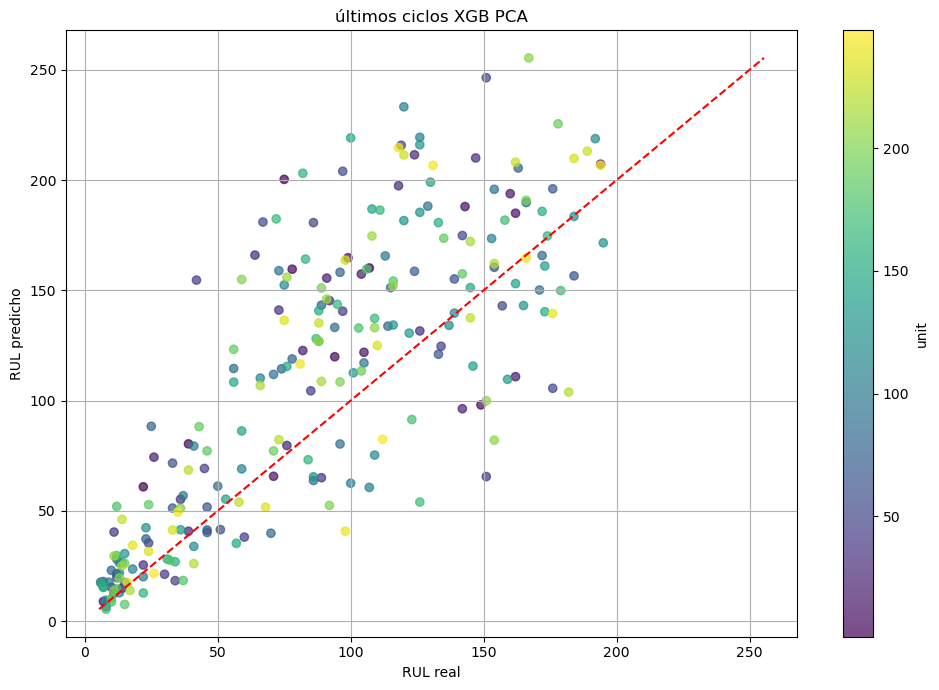

In [43]:
scatter_color_por_columna(results_last_ML, 'RUL','XGB_final','unit', titulo='últimos ciclos XGB PCA')

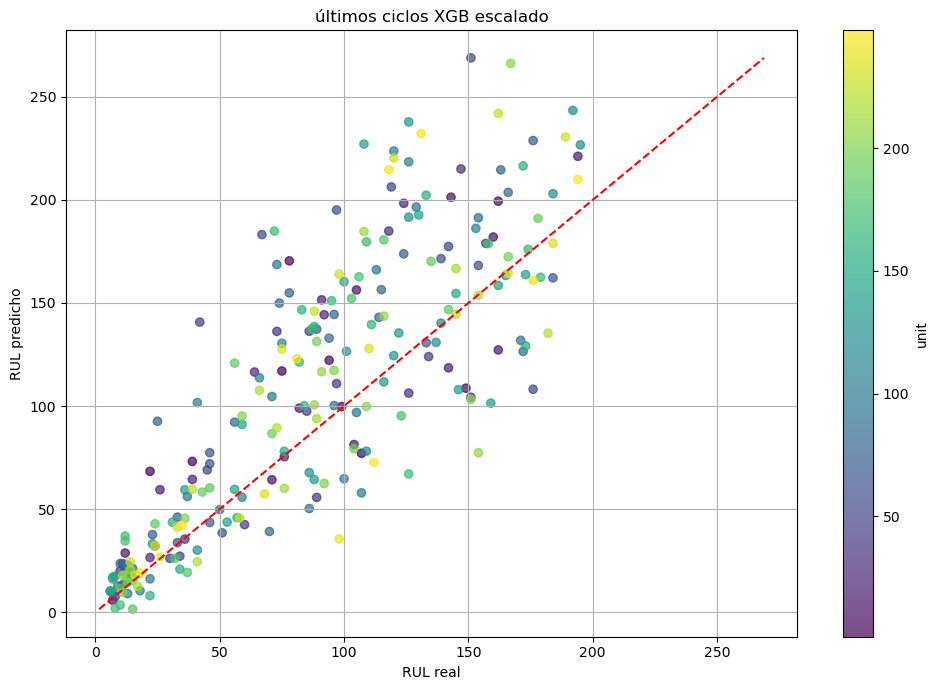

In [44]:
scatter_color_por_columna(results_last_ML, 'RUL','XGB_scaled','unit', titulo='últimos ciclos XGB escalado')

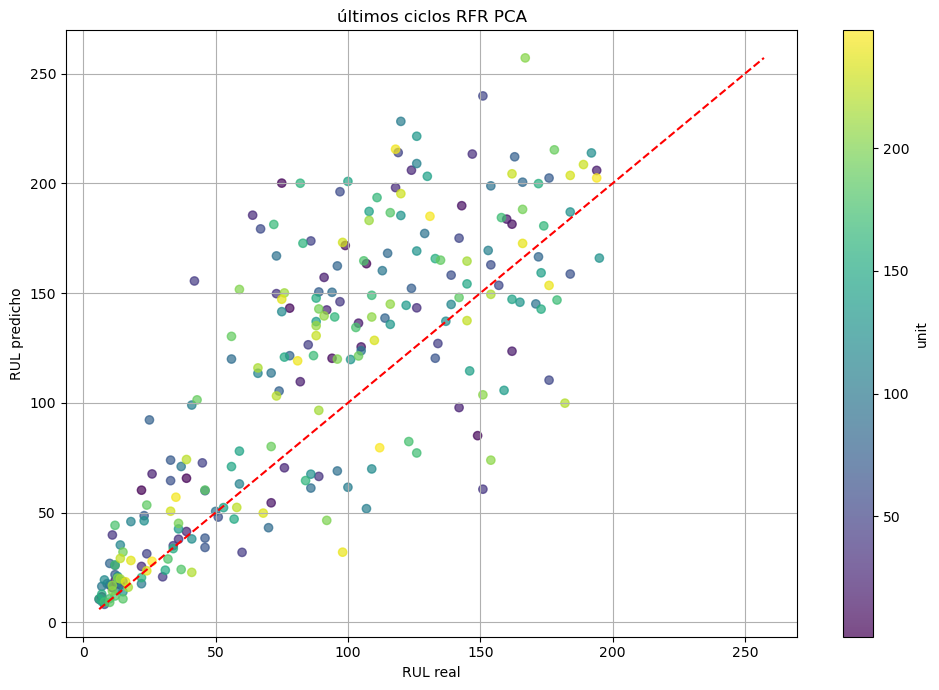

In [45]:
scatter_color_por_columna(results_last_ML, 'RUL','RFR_final','unit', titulo='últimos ciclos RFR PCA')

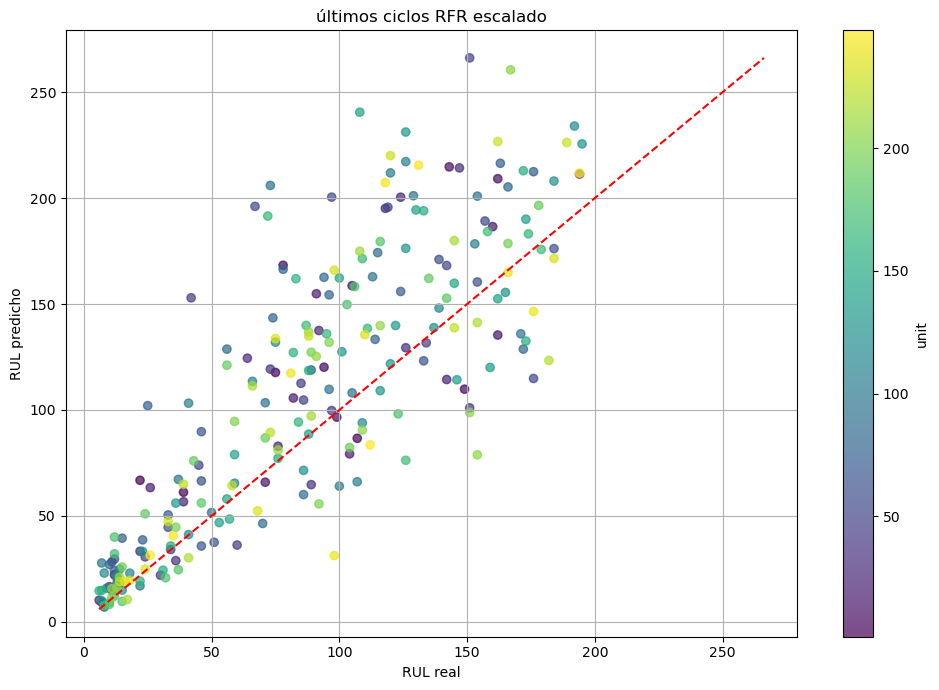

In [46]:
scatter_color_por_columna(results_last_ML, 'RUL','RFR_scaled','unit', titulo='últimos ciclos RFR escalado')

In [47]:
results_last_ML['LSTM_PCA'] = y_pred_LSTM_final_end
results_last_ML['LSTM_Scaled'] = y_pred_LSTM_Scaled_end
results_last_ML_minus_50 = results_last_ML[results_last_ML['RUL'] <= 50]
results_last_ML_minus_50

,unit,cycle,RUL,XGB_final,XGB_scaled,RFR_final,RFR_scaled,LSTM_PCA,LSTM_Scaled
229,1,230,22,60.893875,68.378723,60.214534,66.829306,48.501457,44.453617
382,2,153,39,80.360062,73.185478,65.658393,61.194205,92.900269,99.554321
1230,8,248,14,14.842237,17.771318,17.124177,18.292993,10.210804,12.478516
1889,12,270,7,8.891695,5.892672,11.622171,9.296791,19.604427,10.652536
2386,15,168,12,21.378487,28.754684,18.894558,22.195445,21.569801,15.168113
...,...,...,...,...,...,...,...,...,...
39403,235,362,24,31.597202,32.425156,23.479375,24.884506,29.054579,24.135332
39800,237,221,18,34.379074,19.083128,28.185454,19.506555,39.059177,12.571664
39977,238,177,16,17.476643,18.052282,18.481654,18.929292,10.310283,5.180909
40746,244,184,35,49.426880,42.031246,57.009136,40.707977,56.244209,46.836571


In [48]:
def fixed_check(df, fixed_col, colums_check):
    for col in colums_check:
        rmse = np.sqrt(mean_squared_error(df[fixed_col], df[col]))
        mae = mean_absolute_error(df[fixed_col], df[col])
        r2 = r2_score(df[fixed_col], df[col])

        print(col)
        print(f"RMSE test: {rmse:.4f}")
        print(f"MAE test: {mae:.4f}")
        print(f"R² Score test: {r2:.4f}")
        print("---------------------")

In [49]:
fixed_check(results_last_ML_minus_50, 'RUL', ['XGB_final', 'XGB_scaled', 'RFR_final', 'RFR_scaled', 'LSTM_PCA', 'LSTM_Scaled'])

XGB_final
RMSE test: 22.6358
MAE test: 15.0296
R² Score test: -2.1047
---------------------
XGB_scaled
RMSE test: 20.2786
MAE test: 12.9169
R² Score test: -1.4917
---------------------
RFR_final
RMSE test: 23.3288
MAE test: 14.5842
R² Score test: -2.2977
---------------------
RFR_scaled
RMSE test: 22.3407
MAE test: 13.9699
R² Score test: -2.0243
---------------------
LSTM_PCA
RMSE test: 26.4598
MAE test: 18.0934
R² Score test: -3.2423
---------------------
LSTM_Scaled
RMSE test: 25.6621
MAE test: 15.2625
R² Score test: -2.9903
---------------------
